In [5]:
import pandas as pd
import xgboost as xgb
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold,TimeSeriesSplit, StratifiedKFold, train_test_split
from xgboost import plot_importance
from hyperopt import hp, fmin, tpe, Trials, space_eval

import time

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
df_train_identity = pd.read_csv('../input/train_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')

print(df_train.shape)
del df_train_trans, df_train_identity

(590540, 434)


In [4]:
df_train = reduce_mem_usage(df_train)    

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [4]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
        
    encoded_values = lbl.fit_transform(df_train[col]) 
        
    #Replace the NaN (which becomes -1 after LabelEncoding) with -999
    encoded_values[df_train[col].isnull()] = -999
        
    # Step 5: Assign the encoded values back to the column
    df_train[col] = encoded_values

df_train.fillna(-999, inplace=True)
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 50].index

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")


Columns removed: Index(['dist1', 'dist2', 'R_emaildomain', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12',
       'D13',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=214)
Shape of the cleaned dataframe: (590540, 220)


In [ ]:
# Select only numerical columns
X_train = df_train_cleaned.drop(columns=['isFraud'])
y_train = df_train_cleaned['isFraud']

# Train-test split (80% train, 20% validation)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_final)
df_train_pca = pd.DataFrame(X_train_pca)

In [ ]:
X_train = df_train_pca.drop(columns=['isFraud'])
y_train = df_train_pca['isFraud']

del df_train

custom function objective

In [14]:
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    tss = TimeSeriesSplit(n_splits=FOLDS)

    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, 
            random_state=4, 
            tree_method='hist', 
            device='cuda', 
            eval_metric='auc',
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict_proba(X_vl)[:, 1]  # Get the predicted probabilities for the positive class
        score = roc_auc_score(y_vl, y_pred)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    'gamma': hp.uniform('gamma', 0.01, .7),
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
}

In [15]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=27)

# Print best parameters
best_params = space_eval(space, best)

                                                      
############## New Run ################
params = {'max_depth': 15, 'gamma': '0.294', 'subsample': '0.70', 'reg_alpha': '0.031', 'reg_lambda': '0.309', 'learning_rate': '0.103', 'colsample_bytree': '0.721'}
1 CV - score: 0.8915                                  
2 CV - score: 0.8966                                  
3 CV - score: 0.9153                                  
4 CV - score: 0.8814                                  
5 CV - score: 0.9222                                  
6 CV - score: 0.9175                                  
7 CV - score: 0.9094                                  
Total Time Run: 2.29                                  
Mean ROC_AUC: 0.9048348306010251                      
                                                                                  
############## New Run ################
params = {'max_depth': 17, 'gamma': '0.445', 'subsample': '0.60', 'reg_alpha': '0.063', 'reg_lambda': '0.237', 'learning_

In [17]:
print("BEST PARAMS: ", best_params)
best_params['max_depth'] = int(best_params['max_depth'])

clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='hist', 
    device='cuda', 
)

clf.fit(X_train, y_train)

BEST PARAMS:  {'colsample_bytree': 0.41325685380864785, 'gamma': 0.09378588907506655, 'learning_rate': 0.011488444804382172, 'max_depth': 22.0, 'reg_alpha': 0.3635248350833786, 'reg_lambda': 0.38231836446824635, 'subsample': 0.9}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.41325685380864785, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.09378588907506655, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.011488444804382172,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=22, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
feature_important = clf.get_booster().get_score(importance_type="weight")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top 10 features
data.head(20)

,score
TransactionID,70547.0
card1,56658.0
TransactionAmt,53572.0
card2,51959.0
TransactionDT,50510.0
addr1,36859.0
P_emaildomain,21310.0
card5,20990.0
D15,18715.0
C13,16062.0



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    113975
           1       1.00      0.90      0.94      4133

    accuracy                           1.00    118108
   macro avg       1.00      0.95      0.97    118108
weighted avg       1.00      1.00      1.00    118108



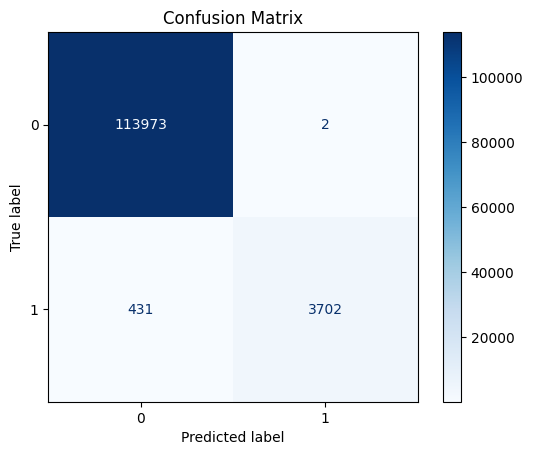

In [19]:
final_params = {
    'max_depth': int(best_params['max_depth']),
    'reg_alpha': float("{:.3f}".format(best_params['reg_alpha'])),
    'reg_lambda': float("{:.3f}".format(best_params['reg_lambda'])),
    'learning_rate': float("{:.3f}".format(best_params['learning_rate'])),
    'colsample_bytree': float("{:.3f}".format(best_params['colsample_bytree'])),
    'gamma': float("{:.3f}".format(best_params['gamma'])),
    'subsample': best_params['subsample'],  # Already selected as a float from choice
}

# Train model with best parameters on full training set
final_model = xgb.XGBClassifier(
    n_estimators=600,
    random_state=4,
    tree_method='hist',  # As per XGBoost >=2.0 best practice
    device='cuda',
    eval_metric='auc',
    **final_params
)

# Fit on full training set
final_model.fit(X_train, y_train)

# Predict on your test/validation set (make sure y_val exists)
y_val_pred = final_model.predict(X_val)

# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()